## This Notebook produces the graphs used in the DMDEnKF paper for the first synthetic experiment:

## Comparing the DMDEnKF/Hankel-DMDEnKF against other iterative DMD variants modelling a sine wave

### First import the relevant dependencies, and set the plotting properties

In [1]:
#Import the relevant dependencies
from DMDEnKF.classes.DMDEnKF import  TDMD, DMDEnKF
import DMDEnKF.helper_functions.simple_sin_functions as ssf
import numpy as np
import matplotlib.pyplot as plt
import cmath
import seaborn as sb
import multiprocessing as mp
import pickle

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Initialise a random seed for reproducibility
np.random.seed(0)

ModuleNotFoundError: No module named 'DMDEnKF'

### Set all data generation and model parameters

In [2]:
#SET ALL PARAMETERS HERE

#Data Params
num_data = 500 -1
num_for_spin_up = 100
theta_start = np.pi/64
theta_end = np.pi/8
thetas = np.linspace(theta_start,theta_end,num_data)
low_obs_cov_const = 0.05**2
high_obs_cov_const = 0.5**2

#SELECT WHETHER USING LOW OR HIGH NOISE
obs_cov_const = high_obs_cov_const


#Model Params
#WTDMD params
window_size = 10

#ODMD params
rho = 0.9

#DMDEnKF/HDMDEnKF params
system_cov_const = (obs_cov_const/10)**2
eig_cov_const = 0.01**2
ensemble_size = 100

#HDMDEnKF params
hankel_dim = 50


#Distributions from multiple runs params
num_runs = 1000
num_to_keep = 400

### Plot the synthetic data we will be fitting to, with both levels of measurement noise

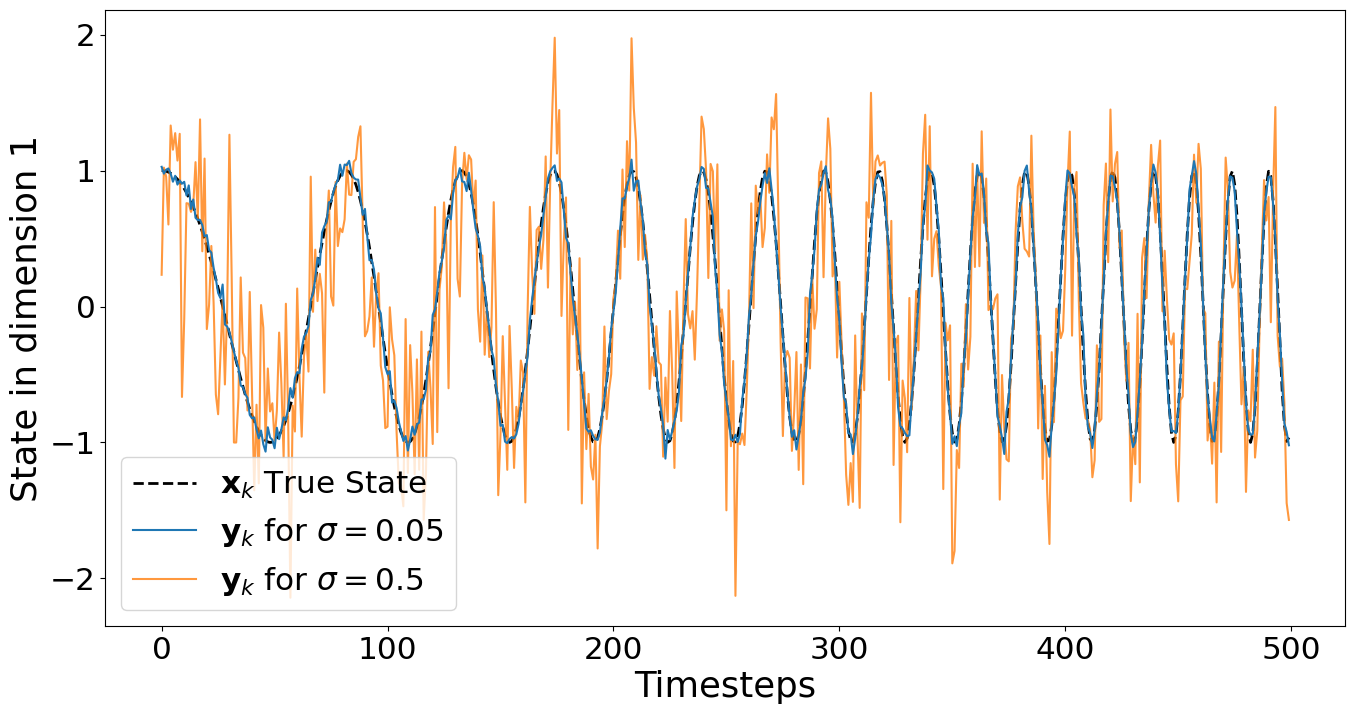

In [3]:
np.random.seed(0)
#use random seed 15 to see a case where standard DMD does not find complex conjugate pair
#np.random.seed(15)
#Generate synthetic data
data = ssf.generate_data(thetas)
true_data = data
noise = np.expand_dims(np.random.multivariate_normal([0]*2,obs_cov_const*np.identity(2),num_data+1),2)
data = data + noise

#plot what the true data, low and high noise cases all look like
noise = np.expand_dims(np.random.multivariate_normal([0]*2,low_obs_cov_const*np.identity(2),num_data+1),2)
n1_data = true_data + noise

noise = np.expand_dims(np.random.multivariate_normal([0]*2,high_obs_cov_const*np.identity(2),num_data+1),2)
n2_data = true_data + noise

plt.plot(true_data[:,0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(n1_data[:,0],alpha=1, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$')
plt.plot(n2_data[:,0],alpha=0.8,color='tab:orange', label=r'$\mathbf{y}_k$ for $\sigma = 0.5$')
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
#plt.savefig('graphs/data_time_series.png',bbox_inches='tight')

### Apply all the iterative DMD variants to the generated high noise data, with the focus on tracking the systems eigenvalues

In [4]:
#apply streaming TDMD
streaming_tdmd_eigs = ssf.iterate_streaming_tdmd(data)
streaming_tdmd_periods = [cmath.polar(x)[1] for x in streaming_tdmd_eigs]

#apply WTDMD
windowed_tdmd_eigs = ssf.windowed_tdmd(data,window_size)
windowed_tdmd_periods = [cmath.polar(x)[1] for x in windowed_tdmd_eigs]

#apply ODMD
odmd_eigs = ssf.iterate_odmd(data, rho)
odmd_periods = [cmath.polar(x)[1] for x in odmd_eigs]

#squeeze data to make into standard format (legacy code from the ghost of bad codemas past)
data = np.squeeze(data).T

#apply DMDEnKF
dmdenkf = ssf.apply_dmdenkf(data,num_for_spin_up,system_cov_const,obs_cov_const,eig_cov_const)
#if model does not find a complex conjugate pair, args must be 0
if not dmdenkf.conj_pair_list:
    dmdenkf_periods = [0]* num_to_keep
#otherwise record the mod and arg as standard
else:
    dmdenkf_periods = [abs(x[-1]) for x in dmdenkf.X][-num_to_keep:]

#apply HDMDEnKF
hdmdenkf = ssf.apply_hankel_dmdenkf(data,num_for_spin_up,hankel_dim,system_cov_const,obs_cov_const,eig_cov_const)
#if model does not find a complex conjugate pair, args must be 0
if not hdmdenkf.conj_pair_list:
    hdmdenkf_periods = [0]* num_to_keep
#otherwise record the mod and arg as standard
else:
    hdmdenkf_periods = [abs(x[-1]) for x in hdmdenkf.X][-num_to_keep:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Plot the iterative DMD variants eigenvalue estimates at each timestep of the high noise data

([<matplotlib.axis.XTick at 0x7f219ab8af50>,
 [Text(0, 0, '100'),
  Text(100, 0, '200'),
  Text(200, 0, '300'),
  Text(300, 0, '400'),
  Text(400, 0, '500')])

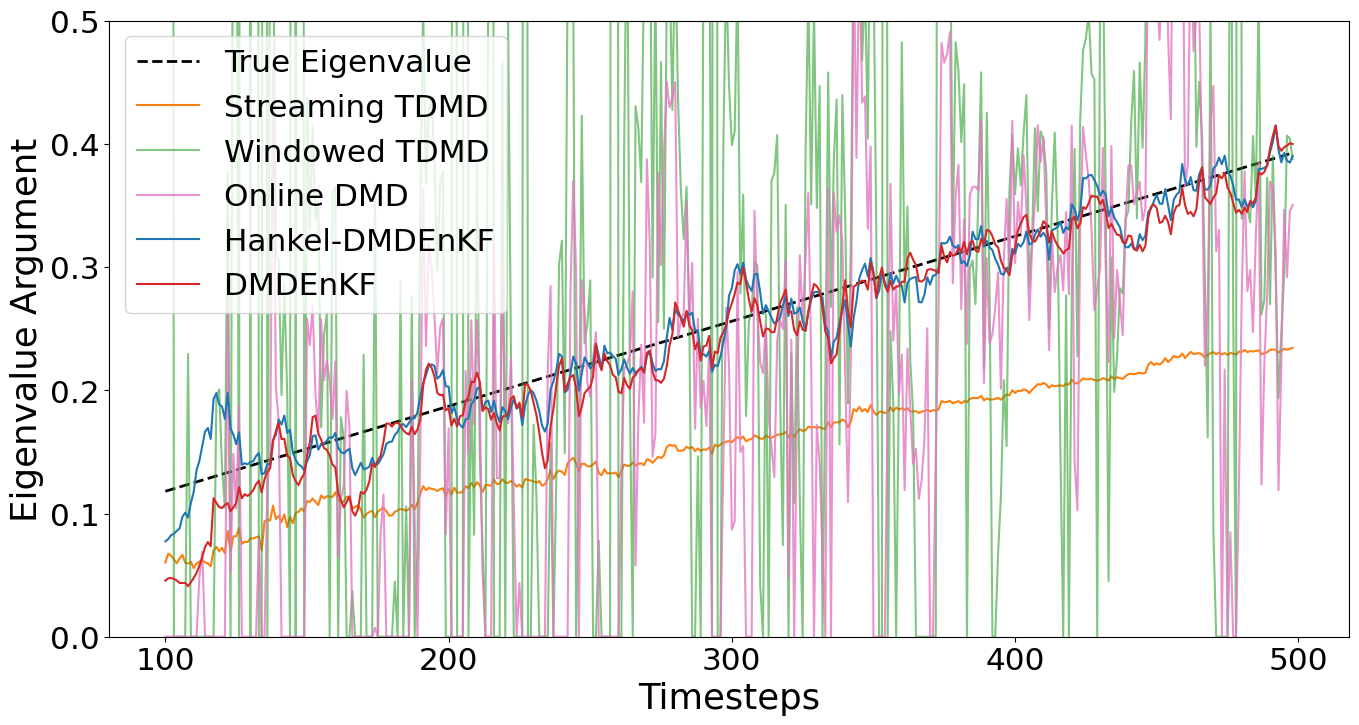

In [5]:
#Plot a typical trajectory of eigenvalue tracking
num_plot = num_data - num_for_spin_up
plt.plot(thetas[-num_plot:],label='True Eigenvalue',c='black',linewidth='2', ls='--')
plt.plot(streaming_tdmd_periods[-num_plot:],label='Streaming TDMD',c='tab:orange')
plt.plot(windowed_tdmd_periods[-num_plot:],label='Windowed TDMD',alpha=0.6,c='tab:green')
plt.plot(odmd_periods[-num_plot:],label='Online DMD',alpha=0.8,c='tab:pink')
plt.plot(hdmdenkf_periods[-num_plot:],label='Hankel-DMDEnKF',c='tab:blue')
plt.plot(dmdenkf_periods[-num_plot:],label='DMDEnKF',c='tab:red')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.ylim(0, 0.5)
xticks = [0,100,200,300,400]
plt.xticks(xticks,[x+100 for x in xticks])
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}_eig_arg_trajectory.png',bbox_inches='tight')

### Run the iterative DMD variants over multiple high noise data trajectories and collect the errors in their estimated eigenvalues at each timestep

 - For convenience, due to the time all the trajectories take to run, this code has already been run. The resulting error distributions have been saved as pickles, and the notebook will automatically load these, and use them to generate the graphs in the rest of the notebook. If you wish to run all data trajectories yourself, simply uncomment the code at the top of the next cell, and comment out the code below which loads from the pickles, then continue with the notebook as normal

In [6]:
'''
#trajectory wrapper so that this code can be run more easily in a asnyncronous manner
def trajectory_wrapper(random_state):
    np.random.seed(random_state)
    #generate data
    data = ssf.generate_data(thetas)
    noise = np.expand_dims(np.random.multivariate_normal([0]*2,obs_cov_const*np.identity(2),500),2)
    data = data + noise
    
    #run trajectory and store outputs in array ordered (STDMD, WTDMD, ODMD, DMDEnKF, HDMDEnKF)
    traj = ssf.run_trajectory(data,num_to_keep,num_for_spin_up,thetas,window_size,rho,obs_cov_const,system_cov_const,eig_cov_const,ensemble_size,hankel_dim)
    print(random_state)
    return traj

#Run trajectories synchronously
for i in range(num_runs):
    if i%1 == 0:
        print(f'Run number: {i}')
    traj = trajectory_wrapper(i)
    if i == 0:
        arg_distributions = traj[0]
        mod_distributions = traj[1]
    else :
        arg_distributions = np.hstack((arg_distributions,traj[0]))
        mod_distributions = np.hstack((mod_distributions,traj[1]))'''

#Code to run trajectories is performed asynchronously in simple_sin_multiprocessing.py,
#then saved as a pickle for ease of use, which is loaded here

with open(f'data/{np.sqrt(obs_cov_const)}simple_sin_distributions.pkl', 'rb') as f:
    distributions = pickle.load(f)
arg_distributions = distributions['args']
mod_distributions = distributions['mods']

### Calculate the mean errors in the eigenvalue modulus estimates for each method on the high noise data

In [7]:
#modulus mean absolute errors for high noise
[np.mean(abs(i)) for i in mod_distributions]

[0.00249579942811888,
 1.3915378609811275,
 0.3057159746815801,
 0.018927993965829802,
 0.01383292333448221]

### Plot the error distributions in the eigenvalue argument estimates for each method on the high noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

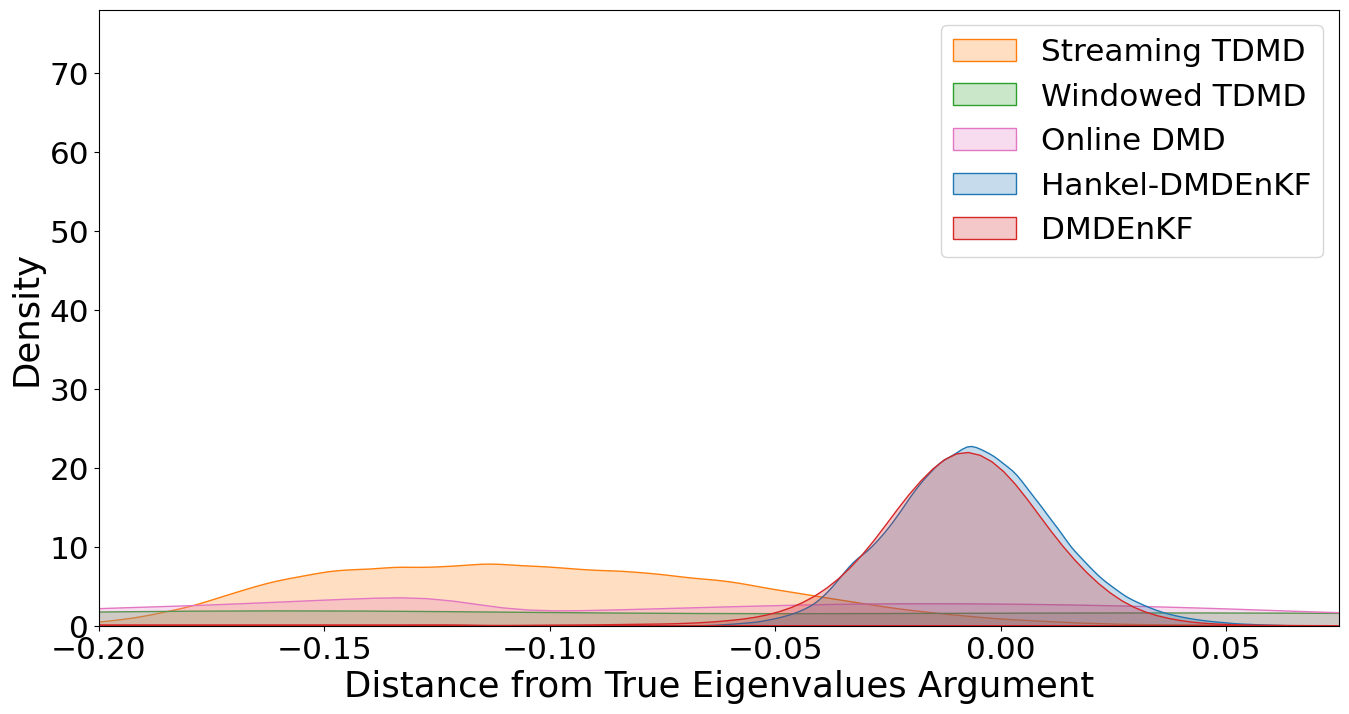

In [8]:
#Plot errror distributions for eigenvlaue argument of each method
sb.distplot(arg_distributions[0],hist=False,kde=True,kde_kws = {'shade': True},label='Streaming TDMD',color='tab:orange')
sb.distplot(arg_distributions[1],hist=False,kde=True,kde_kws = {'shade': True},label='Windowed TDMD',color='tab:green')
sb.distplot(arg_distributions[2],hist=False,kde=True,kde_kws = {'shade': True},label='Online DMD',color='tab:pink')
sb.distplot(arg_distributions[4],hist=False,kde=True,kde_kws = {'shade': True},label='Hankel-DMDEnKF',color='tab:blue')
sb.distplot(arg_distributions[3],hist=False,kde=True,kde_kws = {'shade': True},label='DMDEnKF',color='tab:red')
plt.xlabel('Distance from True Eigenvalues Argument')
plt.ylabel('Density')
plt.ylim(0, 78)
plt.xlim(-0.2, 0.075)
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}_eig_arg_distribution.png',bbox_inches='tight')

### Plot the error distributions in the eigenvalue modulus estimates for each method on the high noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

Text(0, 0.5, 'Density')

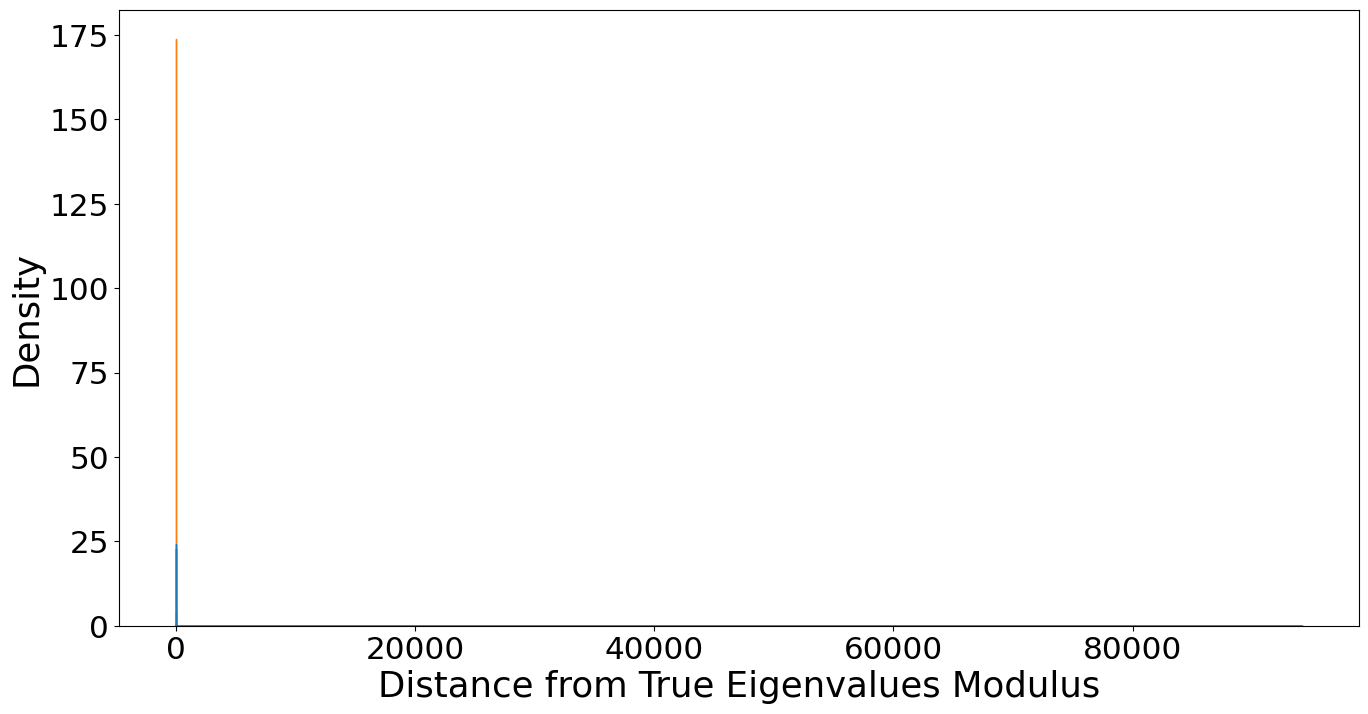

In [9]:
#Plot errror distributions for eigenvlaue modulus of each method
sb.distplot(mod_distributions[0],hist=False,kde=True,kde_kws = {'shade': True},label='Streaming TDMD',color='tab:orange')
sb.distplot(mod_distributions[1],hist=False,kde=True,kde_kws = {'shade': True},label='Windowed TDMD',color='tab:green')
sb.distplot(mod_distributions[2],hist=False,kde=True,kde_kws = {'shade': True},label='Online DMD',color='tab:pink')
sb.distplot(mod_distributions[3],hist=False,kde=True,kde_kws = {'shade': True},label='DMDEnKF',color='tab:red')
sb.distplot(mod_distributions[4],hist=False,kde=True,kde_kws = {'shade': True},label='HDMDEnKF',color='tab:blue')
plt.xlabel('Distance from True Eigenvalues Modulus')
plt.ylabel('Density')
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}_eig_mod_distribution.png',bbox_inches='tight')

### Set the noise variable to the low noise level, then generate low noise data

In [10]:
#CHANGE NOISE SELECTION TO LOW NOISE
obs_cov_const = low_obs_cov_const

#Generate synthetic data
data = ssf.generate_data(thetas)
true_data = data
noise = np.expand_dims(np.random.multivariate_normal([0]*2,obs_cov_const*np.identity(2),num_data+1),2)
data = data + noise

### Apply all the iterative DMD variants to the generated low noise data, with the focus on tracking the systems eigenvalues

In [11]:
#apply streaming TDMD
streaming_tdmd_eigs = ssf.iterate_streaming_tdmd(data)
streaming_tdmd_periods = [cmath.polar(x)[1] for x in streaming_tdmd_eigs]

#apply WTDMD
windowed_tdmd_eigs = ssf.windowed_tdmd(data,window_size)
windowed_tdmd_periods = [cmath.polar(x)[1] for x in windowed_tdmd_eigs]

#apply ODMD
odmd_eigs = ssf.iterate_odmd(data, rho)
odmd_periods = [cmath.polar(x)[1] for x in odmd_eigs]

#squeeze data to make into standard format (legacy code from the ghost of bad codemas past)
data = np.squeeze(data).T

#apply DMDEnKF
dmdenkf = ssf.apply_dmdenkf(data,num_for_spin_up,system_cov_const,obs_cov_const,eig_cov_const)
#if model does not find a complex conjugate pair, args must be 0
if not dmdenkf.conj_pair_list:
    dmdenkf_periods = [0]* num_to_keep
#otherwise record the mod and arg as standard
else:
    dmdenkf_periods = [abs(x[-1]) for x in dmdenkf.X][-num_to_keep:]

#apply HDMDEnKF
hdmdenkf = ssf.apply_hankel_dmdenkf(data,num_for_spin_up,hankel_dim,system_cov_const,obs_cov_const,eig_cov_const)
#if model does not find a complex conjugate pair, args must be 0
if not hdmdenkf.conj_pair_list:
    hdmdenkf_periods = [0]* num_to_keep
#otherwise record the mod and arg as standard
else:
    hdmdenkf_periods = [abs(x[-1]) for x in hdmdenkf.X][-num_to_keep:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Plot the iterative DMD variants eigenvalue estimates at each timestep of the low noise data

([<matplotlib.axis.XTick at 0x7f2198c60670>,
 [Text(0, 0, '100'),
  Text(100, 0, '200'),
  Text(200, 0, '300'),
  Text(300, 0, '400'),
  Text(400, 0, '500')])

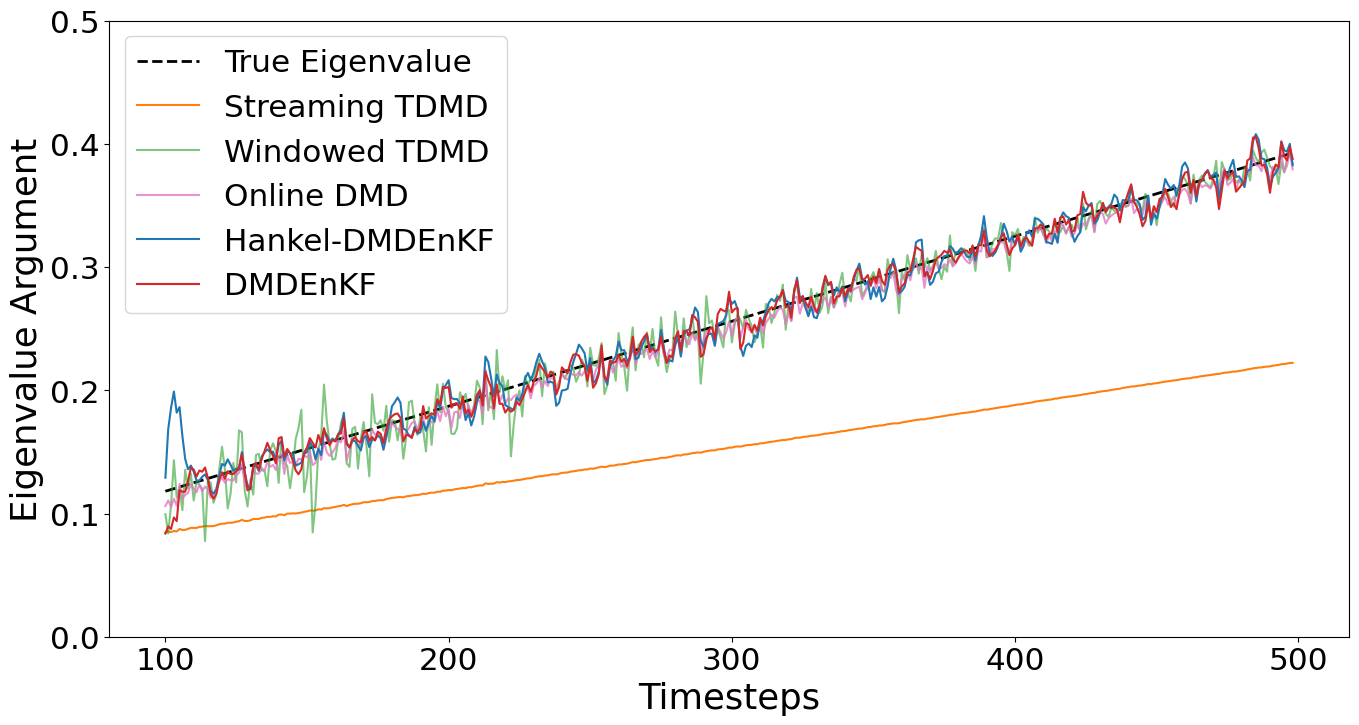

In [12]:
#Plot a typical trajectory of eigenvalue tracking
num_plot = num_data - num_for_spin_up
plt.plot(thetas[-num_plot:],label='True Eigenvalue',c='black',linewidth='2', ls='--')
plt.plot(streaming_tdmd_periods[-num_plot:],label='Streaming TDMD',c='tab:orange')
plt.plot(windowed_tdmd_periods[-num_plot:],label='Windowed TDMD',alpha=0.6,c='tab:green')
plt.plot(odmd_periods[-num_plot:],label='Online DMD',alpha=0.8,c='tab:pink')
plt.plot(hdmdenkf_periods[-num_plot:],label='Hankel-DMDEnKF',c='tab:blue')
plt.plot(dmdenkf_periods[-num_plot:],label='DMDEnKF',c='tab:red')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.ylim(0, 0.5)
xticks = [0,100,200,300,400]
plt.xticks(xticks,[x+100 for x in xticks])
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}_eig_arg_trajectory.png',bbox_inches='tight')

### Load the iterative DMD variants over multiple low noise data trajectories errors in their estimated eigenvalues at each timestep

In [13]:
#Load low noise data from pickle
with open(f'data/{np.sqrt(obs_cov_const)}simple_sin_distributions.pkl', 'rb') as f:
    distributions = pickle.load(f)
arg_distributions = distributions['args']
mod_distributions = distributions['mods']

### Calculate the mean errors in the eigenvalue modulus estimates for each method on the low noise data

In [14]:
#modulus mean absolute errors for high noise
[np.mean(abs(i)) for i in mod_distributions]

[0.0002314994031170293,
 0.00982351883203971,
 0.006042243737251421,
 0.008068116334050704,
 0.009492964611549932]

### Plot the error distributions in the eigenvalue argument estimates for each method on the low noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

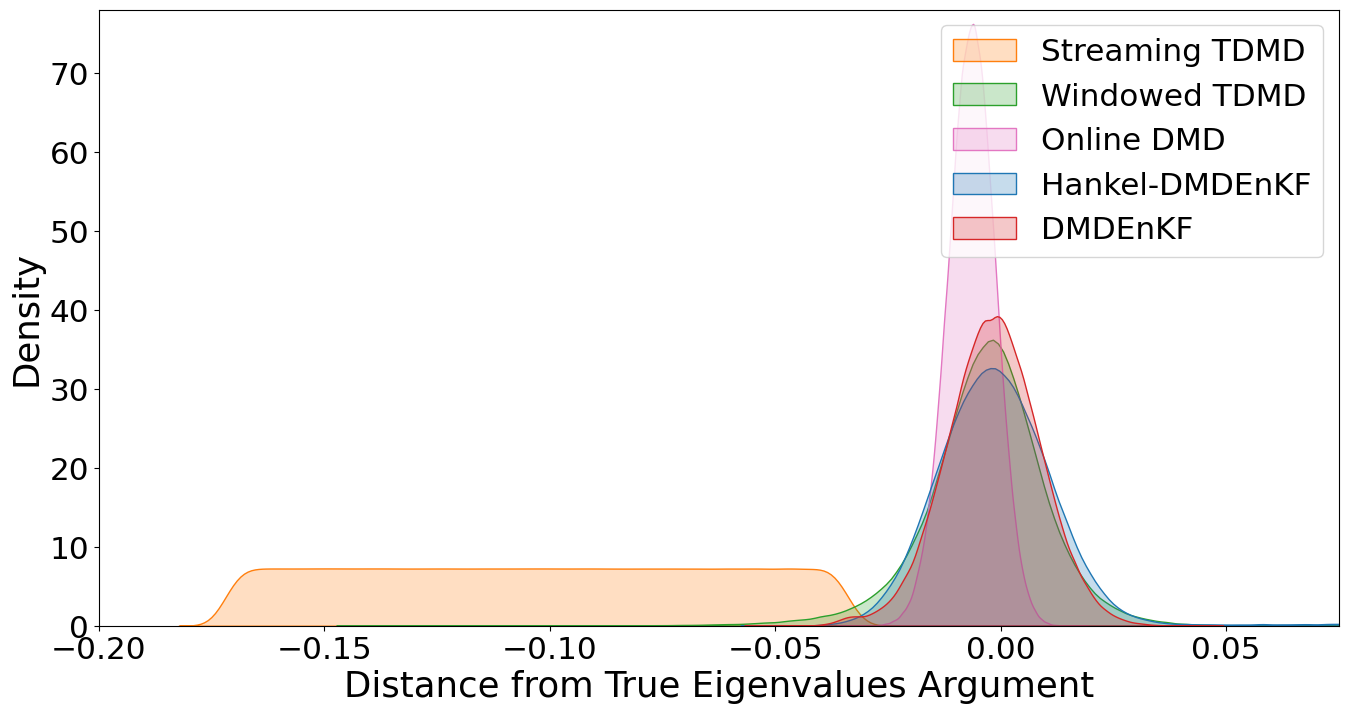

In [15]:
#Plot errror distributions for eigenvlaue argument of each method
sb.distplot(arg_distributions[0],hist=False,kde=True,kde_kws = {'shade': True},label='Streaming TDMD',color='tab:orange')
sb.distplot(arg_distributions[1],hist=False,kde=True,kde_kws = {'shade': True},label='Windowed TDMD',color='tab:green')
sb.distplot(arg_distributions[2],hist=False,kde=True,kde_kws = {'shade': True},label='Online DMD',color='tab:pink')
sb.distplot(arg_distributions[4],hist=False,kde=True,kde_kws = {'shade': True},label='Hankel-DMDEnKF',color='tab:blue')
sb.distplot(arg_distributions[3],hist=False,kde=True,kde_kws = {'shade': True},label='DMDEnKF',color='tab:red')
plt.xlabel('Distance from True Eigenvalues Argument')
plt.ylabel('Density')
plt.ylim(0, 78)
plt.xlim(-0.2, 0.075)
plt.legend()
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}_eig_arg_distribution.png',bbox_inches='tight')

### Plot the error distributions in the eigenvalue modulus estimates for each method on the low noise data

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

Text(0, 0.5, 'Density')

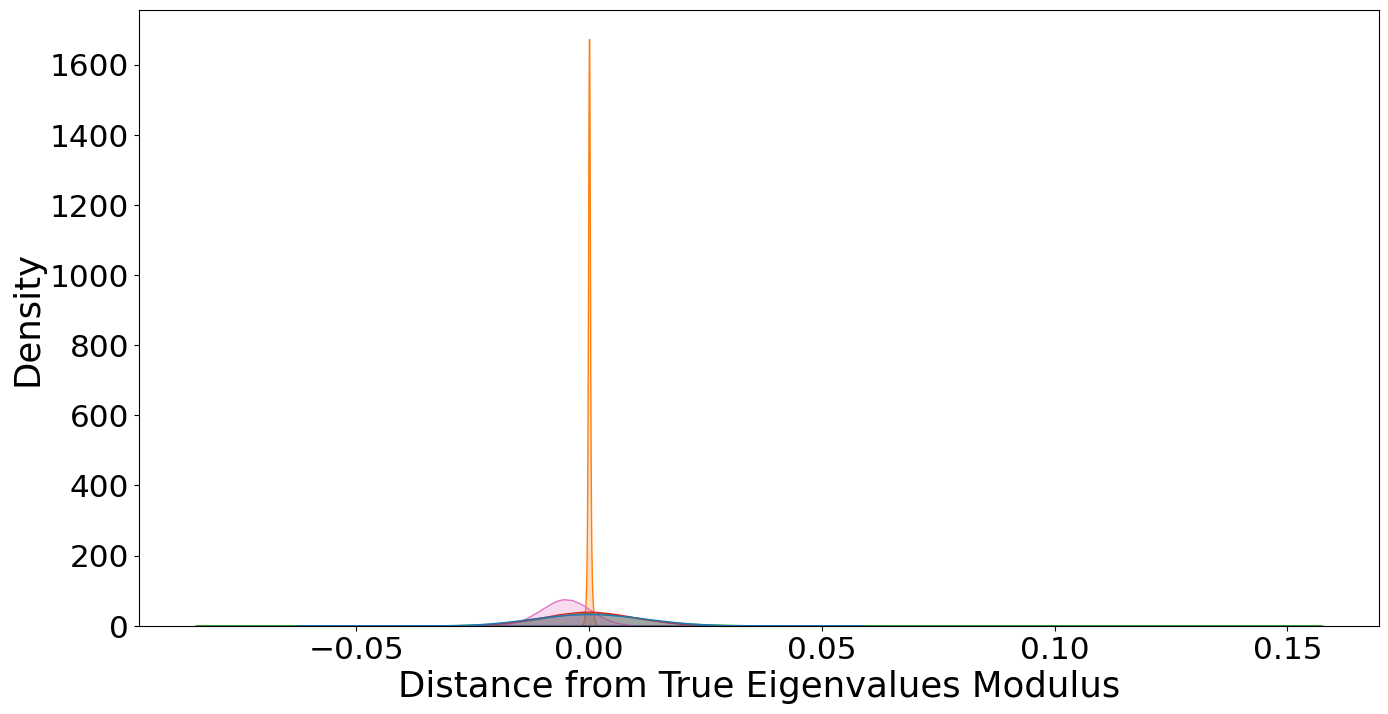

In [16]:
#Plot errror distributions for eigenvlaue modulus of each method
sb.distplot(mod_distributions[0],hist=False,kde=True,kde_kws = {'shade': True},label='Streaming TDMD',color='tab:orange')
sb.distplot(mod_distributions[1],hist=False,kde=True,kde_kws = {'shade': True},label='Windowed TDMD',color='tab:green')
sb.distplot(mod_distributions[2],hist=False,kde=True,kde_kws = {'shade': True},label='Online DMD',color='tab:pink')
sb.distplot(mod_distributions[3],hist=False,kde=True,kde_kws = {'shade': True},label='DMDEnKF',color='tab:red')
sb.distplot(mod_distributions[4],hist=False,kde=True,kde_kws = {'shade': True},label='HDMDEnKF',color='tab:blue')
plt.xlabel('Distance from True Eigenvalues Modulus')
plt.ylabel('Density')
#plt.savefig(f'graphs/{np.sqrt(obs_cov_const)}_eig_mod_distribution.png',bbox_inches='tight')